We model the cell behavior (ion conductances), as well as its inputs (DC injection or synaptic activity) as a perfect ramp and threshold oscillator (green). We know that the applied ES will generate an intracellular perturbation, proportional to the applied ES (orange). The proportionality factor is unique for each cell, as it depends on local field dimensions (distance, shape, orientation), but also on the unique morphology of each cell. Thus, we can model the result of the sinewave ES activity as an intracellular sinewave, and we can control its frequency, amplitude and phase. **Please play with the sliders.**

<IPython.core.display.Javascript object>


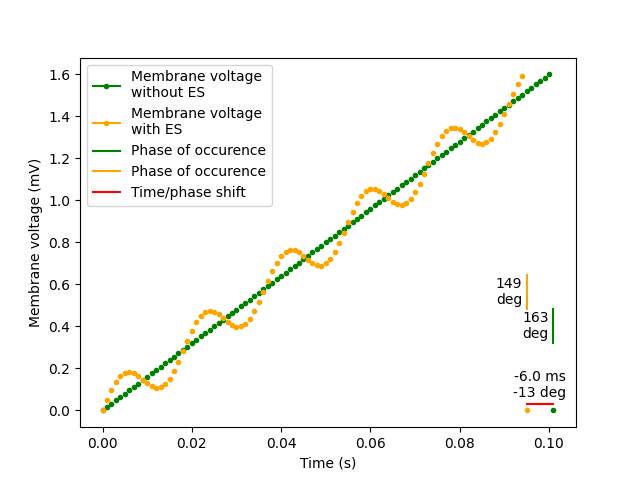

interactive(children=(FloatSlider(value=1.0, description='Thres (mV):', max=2.0, min=0.01, step=0.01), FloatSl…

In [1]:
%matplotlib notebook 
# if the above does not work, try 'widget' instead of 'notebook'

from ipywidgets import interact, FloatSlider
from matplotlib.widgets import Slider
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def Plot(T_threshold, S_slope, F_frequency, A_amplitude, P_phase):
    global ax, fig
    
    dT_step      = 0.001  # s
    V_control    =   0.0  # mV
    V_entrain    =   0.0  # mV
    X_control    =   0.0  # s
    X_entrain    =   0.0  # s
    
    ax.clear()
    
    # Plot control
    while V_control < T_threshold:
        ax.plot(X_control, V_control, marker = '.', color = 'g')
        V_control += S_slope
        X_control += dT_step
    V_control = 0.0
    ax.plot(X_control, V_control, marker = '.', color = 'g', label = 'Membrane voltage\nwithout ES')
    
    # Plot entrain
    V_sup = V_entrain + A_amplitude*np.sin(2*np.pi*X_entrain*F_frequency + P_phase)
    while V_sup < T_threshold:
        ax.plot(X_entrain, V_sup, marker = '.', color = 'orange')
        V_entrain += S_slope
        X_entrain += dT_step
        V_sup = V_entrain + A_amplitude*np.sin(2*np.pi*X_entrain*F_frequency + P_phase)
    V_entrain = 0.0
    ax.plot(X_entrain, V_entrain, marker = '.', color = 'orange', label = 'Membrane voltage\nwith ES')
    
    # Highlight phases
    phofoc = 2 * np.pi * X_control * F_frequency + P_phase
    phofoc = (phofoc % 2*np.pi) * 180 / np.pi 
    ph1 = phofoc
    ax.plot([X_control, X_control], [T_threshold * 0.2, T_threshold * 0.3], color = 'g', label = 'Phase of occurence')
    ax.text(X_control*0.99, T_threshold*0.25, str(int(round(phofoc,0))) + '\ndeg', \
            horizontalalignment='right', verticalalignment='center')
    phofoc = 2 * np.pi * X_entrain * F_frequency + P_phase
    phofoc = (phofoc % 2*np.pi) * 180 / np.pi
    ph2 = phofoc
    ax.plot([X_entrain, X_entrain], [T_threshold * 0.3, T_threshold * 0.4], color = 'orange', label = 'Phase of occurence')
    ax.text(X_entrain*0.99, T_threshold*0.35, str(int(round(phofoc,0))) + '\ndeg', \
            horizontalalignment='right', verticalalignment='center')

    # Highlight dt
    ax.plot([X_entrain, X_control], [T_threshold*0.02, T_threshold*0.02], color = 'r', label = 'Time/phase shift')
    ax.text((X_entrain + X_control)/2, T_threshold*0.075, str(1000*round((X_entrain - X_control),6)) + ' ms\n' + \
            str(int(round((ph2 - ph1),0))) + ' deg', horizontalalignment='center', verticalalignment='center')

    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Membrane voltage (mV)')
    ax.legend()

T_slider = FloatSlider(min=0.01,max=2,step=0.01,value=1,description='Thres (mV):')
S_slider = FloatSlider(min=0.001,max=0.1,step=0.001,value=0.05, readout_format='.3f',description='Slp (mV/dT):')
F_slider = FloatSlider(min=1,max=100,step=1,value=5,description='Freq (Hz):')
A_slider = FloatSlider(min=0.01,max=2,step=0.01,value=0.1,description='Ampl (mV):')
P_slider = FloatSlider(min=0,max=2*np.pi,step=0.01,value=0,description='Phase (rad):')

fig = plt.figure()
ax = fig.add_subplot(111)
interact(Plot, T_threshold = T_slider, S_slope = S_slider, \
         F_frequency = F_slider, A_amplitude = A_slider, \
         P_phase = P_slider)
plt.show()

As we play with the sliders, we observe that any given combination can do nothing more than to shift the expected spike earlier or later in time. However, we also observe that this behavior is not predictable. Slight changes of any parameter, can produce a huge shift of the expected outcome. A typical behavior of chaotic systems. If we actually calculate the resulting time shift of the spike for all ES and FR frequencies, we can see the fractal effect.

In [2]:
def FindLag (FR, F_frequency, A_amplitude = 0.2, P_phase = 0.0):    
    dT_step      = 0.001  # s
    T_threshold  =     1  #mV
    dts = []
    phs = []
    for i in FR:
        dt = []
        ph = []
        S_slope = dT_step * T_threshold * i
        for j in F_frequency:
            V_control    =   0.0  # mV
            V_entrain    =   0.0  # mV
            X_control    =   0.0  # s
            X_entrain    =   0.0  # s

            while V_control < T_threshold:
                V_control += S_slope
                X_control += dT_step

            V_sup = V_entrain + A_amplitude*np.sin(2*np.pi*X_entrain*j + P_phase)
            while V_sup < T_threshold:
                V_entrain += S_slope
                X_entrain += dT_step
                V_sup = V_entrain + A_amplitude*np.sin(2*np.pi*X_entrain*j + P_phase)

            phofoc = 2 * np.pi * X_control * j + P_phase
            phofoc = (phofoc % 2*np.pi) * 180 / np.pi 
            ph1 = phofoc
            phofoc = 2 * np.pi * X_entrain * j + P_phase
            phofoc = (phofoc % 2*np.pi) * 180 / np.pi
            ph2 = phofoc
            dt.append(1000*round((X_entrain - X_control),6)) #ms
            ph.append(int(round((ph2 - ph1),0))) #deg
        dts.append(dt)
        phs.append(ph)
    return dts,phs

<IPython.core.display.Javascript object>


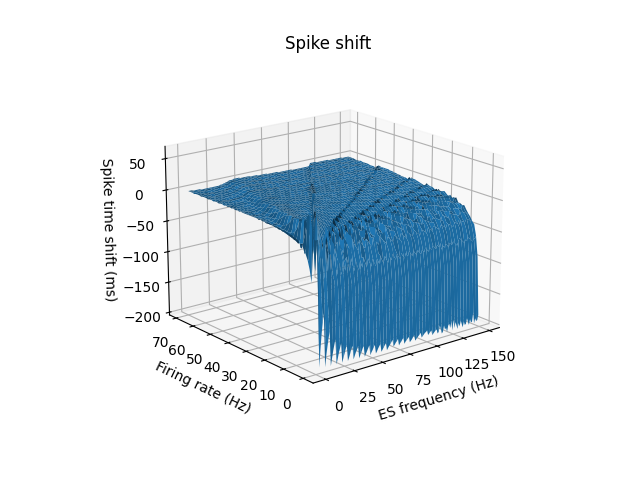

In [3]:
dts,phs = FindLag(np.linspace(1,70,70), np.linspace(1,150,150))
plt.close()
dts = np.array(dts)
X = np.linspace(0, dts.shape[1]-1, dts.shape[1])
Y = np.linspace(0, dts.shape[0]-1, dts.shape[0])
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, dts)

ax.set_title('Spike shift')
ax.set_xlabel('ES frequency (Hz)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_zlabel('Spike time shift (ms)')

plt.show()

It might seem smooth and predictable, but it is not. **Try to rotate and zoom**. In fact, roseplots don't even quantify this spike shift in seconds. They use the corresponding phase of occurence instead, since ground truth of the original dt does not exist in vivo or in vitro.
The results of this decision are horrific.

<IPython.core.display.Javascript object>


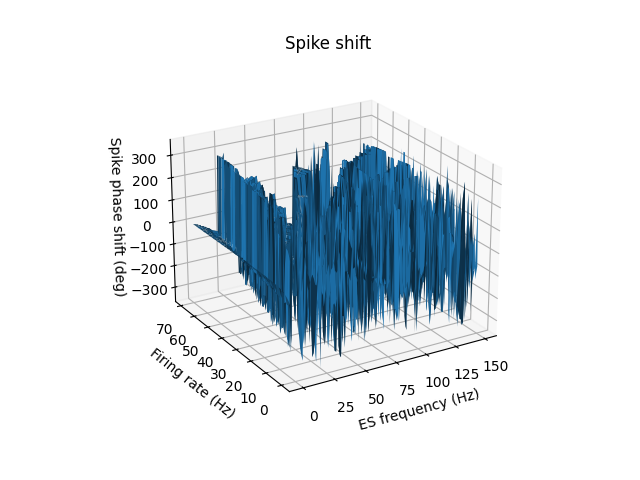

In [4]:
plt.close()
phs = np.array(phs)
X = np.linspace(0, phs.shape[1]-1, phs.shape[1])
Y = np.linspace(0, phs.shape[0]-1, phs.shape[0])
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, phs)

ax.set_title('Spike shift')
ax.set_xlabel('ES frequency (Hz)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_zlabel('Spike phase shift (deg)')

plt.show()

Let's see what happens on a heatmap.

<IPython.core.display.Javascript object>


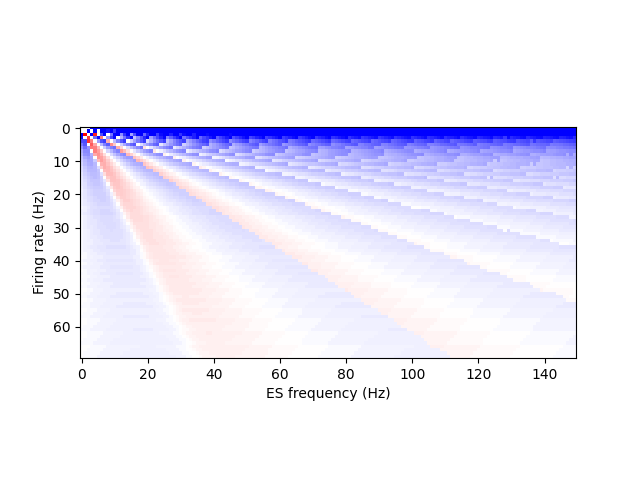

In [5]:
plt.close()
dts = np.array(dts)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(dts, vmin=-50, vmax=50, cmap='bwr') 
ax.set_xlabel('ES frequency (Hz)')
ax.set_ylabel('Firing rate (Hz)')
plt.show()

We see those "rays" of blue, white and red, repeating and shrinking. Blue means that the spike comes earlier, while red means that the spike is delayed. So, the first blue ray is for spikes that happen during the positive phase (semi-period) of the applied ES sinewave. The first white ray is for ES = FR / 2, where there is no effect, while the first red ray is spikes that happen during the negative phase (semi-period) of the applied ES sinewave. The next white ray is for ES = FR, the next for ES = 2 \* FR / 3, and so on. 

We can also see the effect on changes of the ES amplitude or phase.

<IPython.core.display.Javascript object>


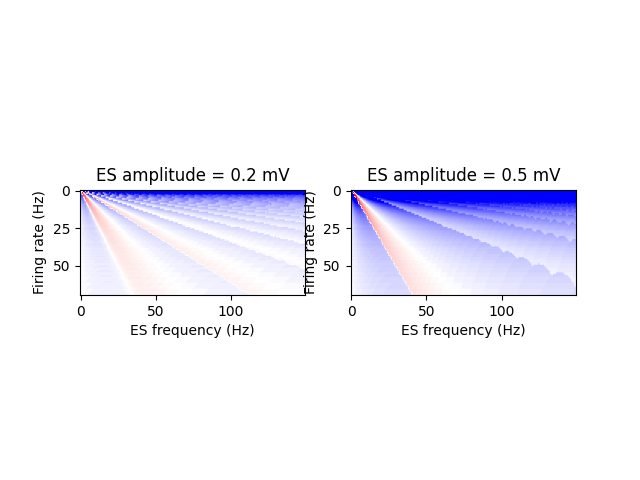

In [6]:
plt.close()
dts,phs = FindLag(np.linspace(1,70,70), np.linspace(1,150,150), A_amplitude = 0.2)
dts = np.array(dts)
fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(dts, vmin=-50, vmax=50, cmap='bwr') 
ax.set_title('ES amplitude = 0.2 mV')
ax.set_xlabel('ES frequency (Hz)')
ax.set_ylabel('Firing rate (Hz)')
dts,phs = FindLag(np.linspace(1,70,70), np.linspace(1,150,150), A_amplitude = 0.5)
dts = np.array(dts)
ax = fig.add_subplot(122)
ax.imshow(dts, vmin=-50, vmax=50, cmap='bwr') 
ax.set_title('ES amplitude = 0.5 mV')
ax.set_xlabel('ES frequency (Hz)')
ax.set_ylabel('Firing rate (Hz)')
plt.show()

We can see that the amplitude increment increases the size of the fractals, and this is the mechanism behind the arnold tongue observations. On the other hand, phase just rotates the "rays".

<IPython.core.display.Javascript object>


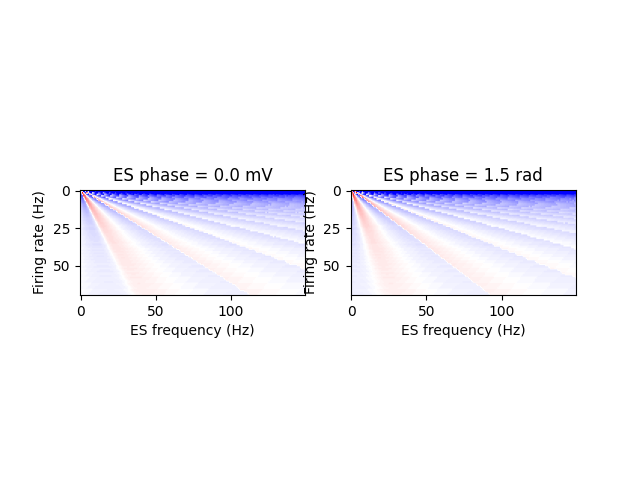

In [7]:
plt.close()
dts,phs = FindLag(np.linspace(1,70,70), np.linspace(1,150,150), P_phase = 0.0)
dts = np.array(dts)
fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(dts, vmin=-50, vmax=50, cmap='bwr') 
ax.set_title('ES phase = 0.0 mV')
ax.set_xlabel('ES frequency (Hz)')
ax.set_ylabel('Firing rate (Hz)')
dts,phs = FindLag(np.linspace(1,70,70), np.linspace(1,150,150), P_phase = 1.5)
dts = np.array(dts)
ax = fig.add_subplot(122)
ax.imshow(dts, vmin=-50, vmax=50, cmap='bwr') 
ax.set_title('ES phase = 1.5 rad')
ax.set_xlabel('ES frequency (Hz)')
ax.set_ylabel('Firing rate (Hz)')
plt.show()

 **NOTE that each cell has a unique heatmap response for every amplitude and every phase, since it presents a unique slope/threshold combination, as well as a unique intracellular response to the applied ES.** In general, any change is capable to create any spike time shift within a range, on any cell.

This means that phase roseplots are not capable to quantify anything. They should be merely used as qualitative indicators that something is happening. On the other hand, roseplots indicating that nothing is happening should not be trusted. As we can see above, almost always, ES does something, except from the cases where FR and ES frequency are harmonics, as well as fractional relations, which create the zero lag diagonal valeys in the plots above. The funny part is that a rose plot at a diagonal valey (of zero shift) will appear super entrained, just because we happen to stimulate and test it close to its inherent frequency. This means that super entrained roseplots do not necessarily indicate a stronger effect on the brain. It can simply be a coincidence.

So, what are we trying to quantify? Arbitrary shifts of spike times is the answer. Why? Because we do not know how the brain works! We do not know if a minor shift of a single spike is capable of a change, and what this change would be. But chaotic systems show that a single spike change can make huge difference. So, keep in mind that **ES always has an effect, even if the roseplots cannot capture it, or even if parkinson is not improved.**

But what do roseplots capture? When do we see an effect? And what is the meaning of what we see?

The answer varies on how we make our plots, and how we define effect. People look for large scale effects, meaning large populations of spikes moving and cohering with the applied ES. So, in general, any disformation of the roseplot does indicate such a thing. However, remember that all spikes of all cells are affected. Roseplot shows if this effect is coherent with the ES frequency, but ignores any preexisting or occuring coherence at any other frequency (except its harmonics). I could say that for every cohering cell, there are 1000 cells affected arbitrarily, and we should not exclude the posibility that those cells fix parkinson.

An ideal roseplot should study the effect of a single applied period of ES on a **uniform cloud of spikes.** Contemporary expectation in this case is that a sinusoidal electrical stimulus will inhibit spikes during its positive half period, and excite the cell during its negative, showing the following roseplot effect.

<IPython.core.display.Javascript object>


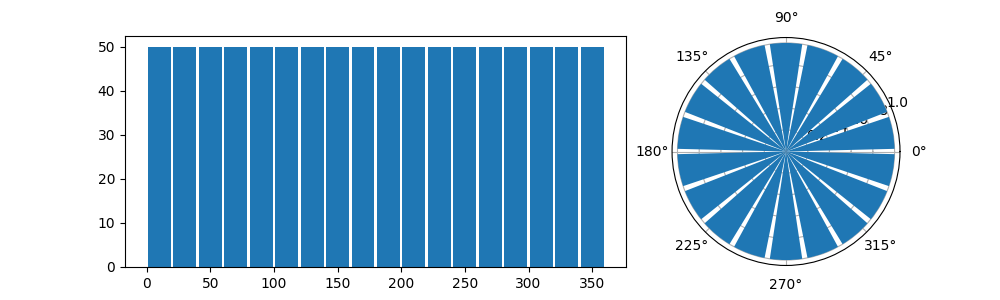

<IPython.core.display.Javascript object>


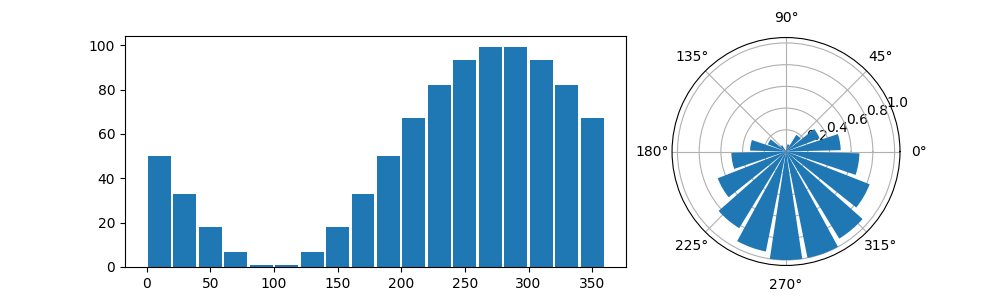

In [8]:
plt.close()
control_hist_X = np.arange(0,361,20)
control_hist_Y = [50]*18

# Plot control histogram and roseplot
fig = plt.figure(figsize = (10,3))
gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, :2])
ax.hist(control_hist_X[:-1], control_hist_X, weights=control_hist_Y, rwidth = 0.9)
ax = fig.add_subplot(gs[0, 2], projection = 'polar')
Y, X = control_hist_Y, control_hist_X
Xp =(X[1:] + X[:-1]) / 2
Xp = Xp * np.pi / 180
normY = np.true_divide(Y, (np.max(Y)))
bars = ax.bar(Xp,normY,width=0.3,edgecolor='None')
ax.set_axisbelow(True)
thetaticks = np.arange(0,360,90)
plt.show()

# Apply ES
ES = np.sin(np.arange(0, np.pi*2, np.pi*2 / 18))
Uniform_Entrained_Y = control_hist_Y-ES*50

# Plot uniform entrained histogram and roseplot
fig = plt.figure(figsize = (10,3))
gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, :2])
ax.hist(control_hist_X[:-1], control_hist_X, weights=Uniform_Entrained_Y, rwidth = 0.9)
ax = fig.add_subplot(gs[0, 2], projection = 'polar')
Y, X = Uniform_Entrained_Y, control_hist_X
Xp =(X[1:] + X[:-1]) / 2
Xp = Xp * np.pi / 180
normY = np.true_divide(Y, (np.max(Y)))
bars = ax.bar(Xp,normY,width=0.3,edgecolor='None')
ax.set_axisbelow(True)
thetaticks = np.arange(0,360,90)
plt.show()

The above is posible if the applied ES is strong enough, but as we have seen so far, the main effect is time displacement. Additionally, the repeating blue/red rays, show that in general spikes that happen during the positive phase (semi-period) of the applied ES sinewave come earlier, while spikes that happen during the negative phase (semi-period) of the applied ES sinewave are delayed. Thus, the following manipulation is closer to reality.

<IPython.core.display.Javascript object>


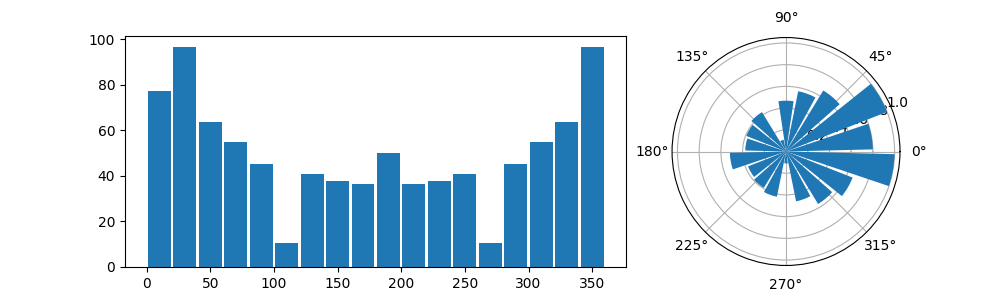

In [9]:
plt.close()
values = control_hist_Y
angles = control_hist_X[:-1]*np.pi/180
bin_move = 3
spike_move = 40
bins_away = -(np.sin(angles)*bin_move).astype(int)
spikes_moved = np.abs(np.sin(angles))*spike_move
for i in range(len(values)):
    values[i] -= spikes_moved[i]
    if bins_away[i]>0 and i<len(values)-bins_away[i]:
        values[i+bins_away[i]] += spikes_moved[i]
    elif bins_away[i]<0 and i>=bins_away[i]:
        values[i+bins_away[i]] += spikes_moved[i]
    elif bins_away[i]>0:
        values[(i+bins_away[i])%len(values)] += spikes_moved[i]
    elif bins_away[i]<0:
        values[len(values)+i+bins_away[i]] += spikes_moved[i]
Time_Entrained_Y = values

# Plot time entrained histogram and roseplot
fig = plt.figure(figsize = (10,3))
gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, :2])
ax.hist(control_hist_X[:-1], control_hist_X, weights=Time_Entrained_Y, rwidth = 0.9)
ax = fig.add_subplot(gs[0, 2], projection = 'polar')
Y, X = Time_Entrained_Y, control_hist_X
Xp =(X[1:] + X[:-1]) / 2
Xp = Xp * np.pi / 180
normY = np.true_divide(Y, (np.max(Y)))
bars = ax.bar(Xp,normY,width=0.3,edgecolor='None')
ax.set_axisbelow(True)
thetaticks = np.arange(0,360,90)
plt.show()

Unfortunately, things do not come as prety, because as we said, each cell has a unique response, a unique phase delay, and thus a unique spike time delay. Therefore, if the cloud is trully uniform and arbitrary we should either see a mild uniform displacement (like the inhibition/excitation plot above the above) or nothing. Maybe in this case the roseplot disformation can be used to define if the selected pool of cells has commonalities in its response or is arbitrary selected (the comonalities might be their FR, their type, or simply their location with respect to the ES electrode). For example cells A respond positive and cells B negative. Merging the results will make the plot more uniform, than testing groups A and B separately.

**The above example is the first indication that pooling data across cells is not very good idea, and should be handled with caution.** But the severe issues arise when we also pool data across time. Meaning that we check multiple repeated aplied sinewave ES periods, combining the results on a single roseplot. Such a plot is useful if we examine the behavior of only one cell. In this case, there is a possibility of a new phenomenon to arise. Pacing. Meaning that the normal firing rate of the cell is  altered in a way that the cell spiking is resonating with the ES, one of its harmonics or an integer fraction of it (2/3, 4/5 etc).

**Cells in a paced state, produce artifact roseplots with the ability to dominate a pooled (across cells) roseplot.** It is highly likely, that those cells had already FR close to an integer fraction (unless our ES is too strong). The effect seems strong on the roseplot, but could be non-existent in the brain. This can easily lead to wrong conclusions due to coincidences.

In fact, as we will see soon, single cell roseplots will either be paced, or arbitrarily affected (almost uniform roseplot), **despite the fact that its ISI always changes**. **Please play with the sliders.**

<IPython.core.display.Javascript object>


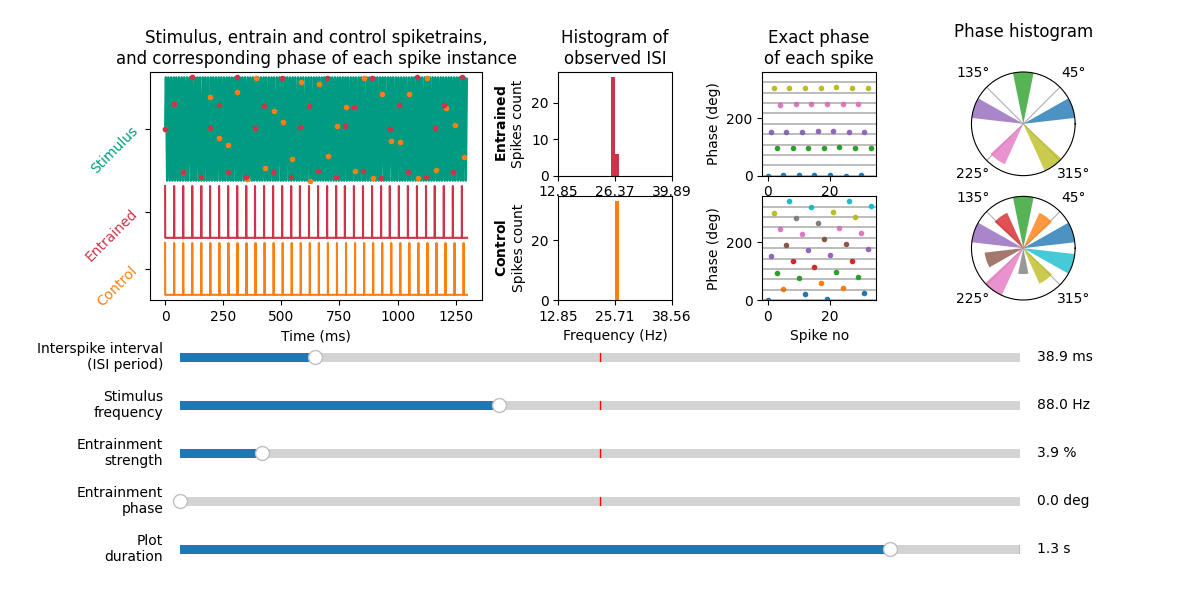

In [10]:
from matplotlib.widgets import Slider
plt.close()
# Set initial values manually here
IS = 10
SF = 50
ES = 0.0
EP = 0.0
DR = 0.2

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
bins = [0, 36, 72, 108, 144, 180, 216, 252, 288, 324, 360]

def GetSine (time_in_ms, freq):
    return np.sin(2*np.pi*t*freq/1000)+1.1

def GetSpike (time_in_ms, isi):
    res = np.zeros(len(time_in_ms))
    point = 0
    res[0] = 1
    nonzer = [0]
    for i in range(2,len(time_in_ms)):
        if (time_in_ms[i]-point)%isi<=0.2 and res[i-1] != 1 and res[i-2] != 1:
            point = time_in_ms[i]
            res[i] = 1
            nonzer.append(i)
    lst = pd.Series(res)
    lst = lst-lst.shift(1)
    lst[0] = 1
    lst[lst<0] = 0
    return lst-2.1, np.array(nonzer)

def GetSpikeEntrained (time_in_ms, isi, entstr, entrph, stimf):
    res = np.zeros(len(time_in_ms))
    point = 0
    res[0] = 1
    nonzer = [0]
    for i in range(2,len(time_in_ms)):
        if (time_in_ms[i]-point)%isi<=0.2 and res[i-1] != 1 and res[i-2] != 1:
            point = time_in_ms[i]
            res[i] = 1
            nonzer.append(i)
        elif (time_in_ms[i]-point)%isi>(1-entstr/100)*isi and abs((time_in_ms[i]%(1000/stimf))*360/(1000/stimf)-entrph)<3:
            point = time_in_ms[i]
            res[i] = 1
            nonzer.append(i)
    lst = pd.Series(res)
    lst = lst-lst.shift(1)
    lst[0] = 1
    lst[lst<0] = 0
    return lst-1, np.array(nonzer)

def GetIsis (inds):
    return 10000/(inds[1:]-inds[:-1])

def MultiColorDraw (data, ax):
    for j,s in enumerate(data):
        if s<bins[1]:
            colore = colors[0]
        elif s<bins[2]:
            colore = colors[1]
        elif s<bins[3]:
            colore = colors[2]
        elif s<bins[4]:
            colore = colors[3]
        elif s<bins[5]:
            colore = colors[4]
        elif s<bins[6]:
            colore = colors[5]
        elif s<bins[7]:
            colore = colors[6]
        elif s<bins[8]:
            colore = colors[7]
        elif s<bins[9]:
            colore = colors[8]
        else:
            colore = colors[9]
        ax.plot(j,s, '.', color = colore)
        for k in bins:
            ax.axhline(y = k, color = 'grey', linestyle = '-', linewidth = 0.1, alpha = 0.2)

def RoseDraw (data, ax):
    Y, X = np.histogram(data, bins=[0, 36, 72, 108, 144, 180, 216, 252, 288, 324, 360])
    Xp =(X[1:] + X[:-1]) / 2
    Xp = Xp * np.pi / 180
    normY = np.true_divide(Y, (np.max(Y)))
    bars = ax.bar(Xp, normY,  width=0.4, color=colors, alpha=0.8)
    ax.set_axisbelow(True)
    ax.set_ylim([0,1])
    ax.set_yticks([])
    ax.set_xticks([np.pi/4,np.pi*3/4,np.pi*5/4,np.pi*7/4])

def update(val):
    global t, IS, SF, ES, EP, DR, SI, SP, IN, ISs, PSs
    IS = ISI_slider.val
    SF = Freq_slider.val
    ES = EntrStrength_slider.val
    EP = EntrPhase_slider.val
    DR = Duration_slider.val
    t = np.arange(0.0, DR*1000, 0.1)
    SI = GetSine(t, SF)
    SP, IN = GetSpike(t, IS)
    SPen, INen = GetSpikeEntrained(t, IS, ES, EP, SF)
    PSs = (IN/10%(1000/SF))*360/(1000/SF)
    PSsen = (INen/10%(1000/SF))*360/(1000/SF)
    ISs = GetIsis(IN)
    ISsen = GetIsis(INen)
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()
    ax7.clear()
    ax1.set_title('Stimulus, entrain and control spiketrains,\nand corresponding phase of each spike instance')
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylim(-2.2,2.2)
    ax1.set_yticks([-1.6,-0.5,1.1])
    ax1.set_yticklabels(['Control', 'Entrained', 'Stimulus'], rotation=45)
    ax1.get_yticklabels()[0].set_color("#FE7F11")
    ax1.get_yticklabels()[1].set_color("#CD3449")
    ax1.get_yticklabels()[2].set_color("#009B81") 
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('$\\bf{Control}$\nSpikes count')
    ax2.set_xlim(np.min(ISs)/2, np.max(ISs)*1.5)
    ax2.set_xticks([np.min(ISs)/2, np.min(ISs)/2+(np.max(ISs)*1.5-np.min(ISs)/2)/2, np.max(ISs)*1.5])
    ax5.set_ylabel('$\\bf{Entrained}$\nSpikes count')
    ax5.set_xlim(np.min(ISsen)/2, np.max(ISsen)*1.5)
    ax5.set_xticks([np.min(ISsen)/2, np.min(ISsen)/2+(np.max(ISsen)*1.5-np.min(ISsen)/2)/2, np.max(ISsen)*1.5])
    ax5.set_title('Histogram of\nobserved ISI')
    ax3.set_xlabel('Spike no')
    ax3.set_ylabel('Phase (deg)')
    ax3.set_ylim(0,360)
    ax6.set_ylabel('Phase (deg)')
    ax6.set_ylim(0,360)
    ax6.set_title('Exact phase\nof each spike')
    ax7.set_title('Phase histogram\n')
    ax1.plot(t, SI, color = '#009B81')
    ax1.plot(t, SP, color = '#FE7F11')
    ax1.plot(t, SPen, color = '#CD3449')
    ax1.plot(IN/10, SI[IN], '.', color = '#FE7F11')
    ax1.plot(INen/10, SI[INen], '.', color = '#CD3449')
    ax2.hist(ISs, range = (np.min(ISs)/2,np.max(ISs)*1.5), bins = 30, color = '#FE7F11')
    MultiColorDraw (PSs, ax3)
    RoseDraw (PSs, ax4)
    ax5.hist(ISsen, range = (np.min(ISsen)/2,np.max(ISsen)*1.5), bins = 30, color = '#CD3449')
    MultiColorDraw (PSsen, ax6)
    RoseDraw (PSsen, ax7)
  
# Create figure
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(2, 5, 8)
ax3 = fig.add_subplot(2, 5, 9)
ax4 = fig.add_subplot(2, 5, 10, projection='polar')
ax5 = fig.add_subplot(2, 5, 3)
ax6 = fig.add_subplot(2, 5, 4)
ax7 = fig.add_subplot(2, 5, 5, projection='polar')
plt.subplots_adjust(bottom = 0.5, wspace = 0.8)

# Initialize sliders
ISI_axis = plt.axes([0.15, 0.39, 0.7, 0.03])
Freq_axis = plt.axes([0.15, 0.31, 0.7, 0.03])
EntrStrength_axis = plt.axes([0.15, 0.23, 0.7, 0.03])
EntrPhase_axis = plt.axes([0.15, 0.15, 0.7, 0.03])
Duration_axis = plt.axes([0.15, 0.07, 0.7, 0.03])
ISI_slider = Slider(ISI_axis, 'Interspike interval\n(ISI period)', 10.0, 190.0, valinit = 100, valfmt = '%0.1f'+' ms')
Freq_slider = Slider(Freq_axis, 'Stimulus\nfrequency', 50.0, 150.0, valinit = 100, valfmt = '%0.1f'+' Hz')
EntrStrength_slider = Slider(EntrStrength_axis, 'Entrainment\nstrength', 0.0, 40.0, valinit = 20, valfmt = '%0.1f %%')
EntrPhase_slider = Slider(EntrPhase_axis, 'Entrainment\nphase', 0.0, 359.9, valinit = 180, valfmt = '%0.1f'+' deg')
Duration_slider = Slider(Duration_axis, 'Plot\nduration', 0.2, 1.5, valinit = 2.5, valfmt = '%0.1f'+' s')

ISI_slider.valinit = IS
Freq_slider.valinit = SF
EntrStrength_slider.valinit = ES
EntrPhase_slider.valinit = EP
Duration_slider.valinit = DR
ISI_slider.reset()
Freq_slider.reset()
EntrStrength_slider.reset()
EntrPhase_slider.reset()
Duration_slider.reset()

# Slider interrupts
update(0)
ISI_slider.on_changed(update)
Freq_slider.on_changed(update)
EntrStrength_slider.on_changed(update)
EntrPhase_slider.on_changed(update)
Duration_slider.on_changed(update)

plt.show()

This last plot is using a simplified equation, instead of the accurate version of the first plot. This is necessary for fast interaction, without compromising the effects. The pacing effect remains and can be observed. 

Conclusions: The lack of ground ISI truth made us evaluate things on a phase domain. As we saw, this is introducing fractal dimensions and artifacts. Things would be better if we could evaluate on a frequency domain, or best, if we could evaluate on the time domain (ISI). Until then, be careful on how you make and read roseplots. Pooling accross cells is bad, especially if you also pool accross time. Remember that a uniform plot does not prove absence of effect, while an entrained plot does not prove existence of (strong) effect. 

Finally, keep in mind that vector length metric is useless, since the expected roses are never uniform. See next notebook for MMR.